# Projet numérique de science des données - Bonhomme Vermeer et Rigaut Gaétan

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd

In [5]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [6]:
df_public

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0
...,...,...,...,...,...,...,...,...,...,...,...
5995,2935,41,13,42,9,4692,221,211,123,2080,1
5996,2931,17,9,30,5,4722,213,221,145,2064,1
5997,2932,323,7,0,0,4752,202,233,170,2048,1
5998,2935,294,6,0,0,4782,202,239,176,2032,1


### Extraction de la matrice de design et des étiquettes 

In [7]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

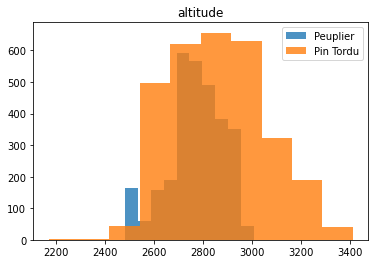

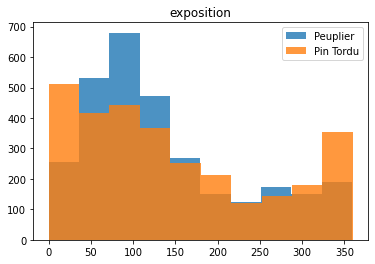

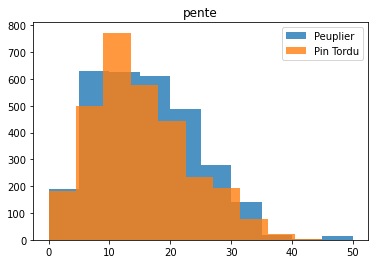

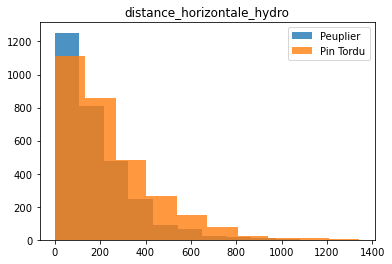

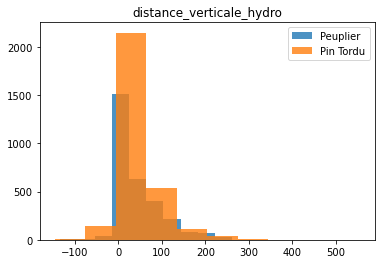

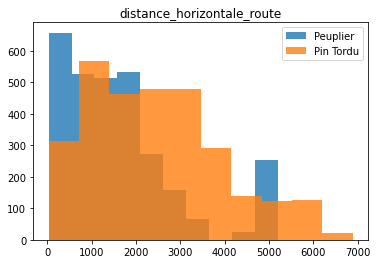

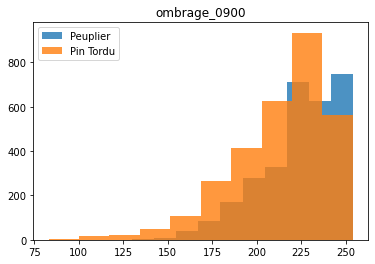

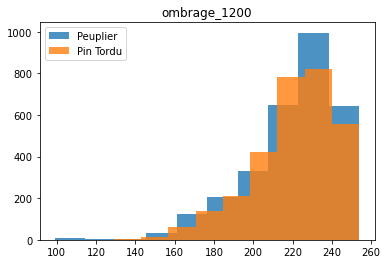

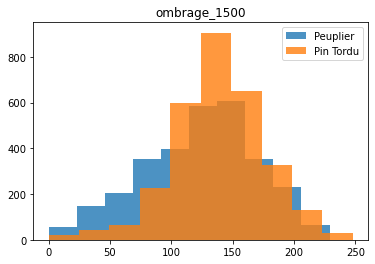

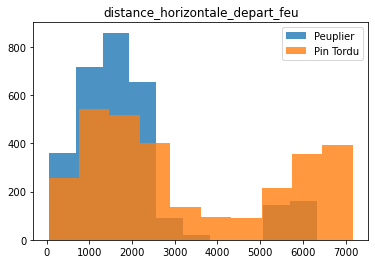

In [8]:
pos_indices = np.where(y_public==1)[0]
pos_indices_2 = np.where(y_public==0)[0]
for i in range(10) :
    plt.hist([e[i] for e in X_public[pos_indices]],alpha=0.8)
    plt.hist([e[i] for e in X_public[pos_indices_2]],alpha = 0.8)
    plt.title(df_public.columns.values[i])
    plt.legend(['Peuplier','Pin Tordu'])
    plt.show()

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Non car beaucoup de variables ont les mêmes profils d'histogrammes

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. 

Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

Nous choisissons de centrer réduire les valeurs, pour ne pas que leurs différents ordres de grandeurs n'influent sur les algorithme de classification qu enous allons utiliser

In [9]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)
X_public_preprocessed = standard_scaler.transform(X_public)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [10]:
from sklearn import neighbors

In [11]:
predictor_neigh = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor_neigh.fit(X_public_preprocessed, y_public)

y_pred_neigh = predictor_neigh.predict(X_public_preprocessed)

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

In [12]:
from sklearn import metrics
print("performances sur un modèle naïf : {}".format(metrics.f1_score(y_public,np.ones((len(y_public))))))

performances sur un modèle naïf : 0.6666666666666666


En effet : 
    
    Précision = 0.5
    Rappel = 1
    F = 2*(Précision*Rappel)/(Précision+Rappel) = 2/3
    

#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [13]:
f1_5NN = metrics.f1_score(y_public,y_pred_neigh)
print("performances sur le set complet : {}".format(f1_5NN))

performances sur le set complet : 0.9290079924776682


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

C'est un résultat satisfaisant. Cependant, on vient de tester la prédiction sur les données qui ont servi a créer le modèle, donc le score obtenu n'est pas représentatif de la performance du modèle. Il y a en effet un risque de surapprentissage : si k=1, on prend exactement l'étiquette du point. Ainsi, on n'obtient jamais d'erreur mais en réalité c'est uniquement de "l'apprentissage par coeur".

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [14]:
from sklearn import model_selection

In [15]:
# Use 20% for testing
X_train_public, X_test_public, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
#On centre-réduit les valeurs

standard_scaler_train = preprocessing.StandardScaler()
standard_scaler_train.fit(X_train_public)
X_train = standard_scaler_train.transform(X_train_public)

standard_scaler_test = preprocessing.StandardScaler()
standard_scaler_test.fit(X_test_public)
X_test = standard_scaler_test.transform(X_test_public)

X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [16]:
predictor_neigh_sep = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor_neigh_sep.fit(X_train,y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [17]:
y_pred_5NN = predictor_neigh_sep.predict(X_test)
print("performances sur le set de test : {}".format(metrics.f1_score(y_test, y_pred_5NN)))

performances sur le set de test : 0.9019908116385911


#### Question 9
Commentez le F-score obtenu ci-dessus.

Il est du même ordre que celui obtenu auparavant, mais il est plus 'significatif', on sait que l'algorithme a de telles performances sur des données qu'il n'a jamais vu.

Cette fois nous pouvons tester la prédiction avec k=1 :

In [18]:
predictor_neigh_sep_Q9 = neighbors.KNeighborsClassifier(n_neighbors=1)
predictor_neigh_sep_Q9.fit(X_train,y_train)
y_pred_5NN_Q9 = predictor_neigh_sep_Q9.predict(X_test)
print("performances sur le set de test : {}".format(metrics.f1_score(y_test, y_pred_5NN_Q9)))

performances sur le set de test : 0.9132492113564669


Cette fois-ci la prédiction n'est pas parfaite. Et le test est prend du sens car cette fois l'algorithme n'a "jamais vu" les données avec lesquelle il est testé.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [19]:
k_values = np.arange(3,32, step=2)

In [20]:
from sklearn.model_selection import GridSearchCV

predictor_neigh_grid = neighbors.KNeighborsClassifier()

# define gridsearch
tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid = GridSearchCV(predictor_neigh_grid, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])}],
             scoring=make_scorer(f1_score))

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [21]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016387,0.003748,0.135719,0.045351,3,{'n_neighbors': 3},0.897881,0.901163,0.889952,0.883412,0.908913,0.896264,0.008850,1
1,0.016579,0.001349,0.142767,0.035339,5,{'n_neighbors': 5},0.892754,0.892514,0.886124,0.871843,0.894027,0.887452,0.008275,2
2,0.017279,0.000584,0.119758,0.010164,7,{'n_neighbors': 7},0.888676,0.886990,0.879392,0.860315,0.891841,0.881443,0.011330,3
3,0.023676,0.006263,0.174599,0.064724,9,{'n_neighbors': 9},0.879849,0.878417,0.870877,0.861368,0.877589,0.873620,0.006859,4
4,0.023097,0.007982,0.242345,0.068891,11,{'n_neighbors': 11},0.870388,0.876173,0.867675,0.859796,0.878187,0.870444,0.006540,6
5,0.018993,0.005189,0.181444,0.040566,13,{'n_neighbors': 13},0.870633,0.878505,0.867357,0.855019,0.880907,0.870484,0.009187,5
6,0.021307,0.008803,0.195908,0.029048,15,{'n_neighbors': 15},0.868744,0.871415,0.868668,0.850554,0.878049,0.867486,0.009129,7
7,0.016181,0.003548,0.191462,0.028849,17,{'n_neighbors': 17},0.864662,0.871415,0.863039,0.848206,0.872897,0.864044,0.008774,8
8,0.027166,0.011295,0.184499,0.027157,19,{'n_neighbors': 19},0.860356,0.865314,0.865169,0.844240,0.873134,0.861642,0.009618,9
9,0.019508,0.005853,0.171771,0.031485,21,{'n_neighbors': 21},0.856876,0.862419,0.860335,0.843750,0.876404,0.859957,0.010477,10


In [22]:
print("Le meilleur F1-score associé au nombre de voisins optimal est : {}".format(grid.best_score_))

Le meilleur F1-score associé au nombre de voisins optimal est : 0.8962641272279832


#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [23]:
predictor_neigh_best = neighbors.KNeighborsClassifier(n_neighbors=3)
predictor_neigh_best.fit(X_train,y_train)
y_pred_neigh_grid = predictor_neigh_best.predict(X_test)
f1_neigh_grid = metrics.f1_score(y_pred_neigh_grid,y_test)
print("performances sur le set de test : {}".format(f1_neigh_grid))

performances sur le set de test : 0.9010819165378671


Le résultat de ce F-score est plus élevé que celui obtenu par la méthode grid. Cela nous indique que la population d'entrainement n'est pas tout à fait réprésentative de la population de jeu

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [24]:
from sklearn.linear_model import LogisticRegression
predictor_logreg = LogisticRegression(penalty='none')
predictor_logreg.fit(X_train,y_train)
y_pred_logreg=predictor_logreg.predict(X_test)

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [25]:
f1_logreg_none = metrics.f1_score(y_pred_logreg,y_test)
print("performances sur le set de test : {}".format(f1_logreg_none))

performances sur le set de test : 0.776954732510288


In [26]:
print("performances sur le set d'entrainement : {}".format(metrics.f1_score(predictor_logreg.predict(X_train),y_train)))

performances sur le set d'entrainement : 0.7724933086267243


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

On constate que les performances de prediction sur le jeu de test sont les mêmes que celles sur le jeu d'entrainement. Ainsi, il n'y a, a priori, pas de sur-apprentissage de la part du modèle. Une régularisation (L2) ne devrait donc pas modifier les performances du modèle, qui parvient déjà à généraliser.  

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [27]:
C_values = np.logspace(-2, 2, 50)

In [28]:
from sklearn.model_selection import GridSearchCV

predictor_logreg_grid = LogisticRegression(penalty='l2')

# define gridsearch
tuned_parameters = [{'C': C_values}]
nb_folds = 5
grid_ridge = GridSearchCV(predictor_logreg_grid, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_ridge.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01, 2.94705...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])}],
             scoring=make_scorer(f1_score))

In [29]:
pd.DataFrame(grid_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034674,0.008560,0.002397,0.001957,0.01,{'C': 0.01},0.773663,0.765073,0.771930,0.761044,0.778689,0.770080,0.006278,42
1,0.045883,0.005623,0.003905,0.003629,0.0120679,{'C': 0.012067926406393288},0.775258,0.769710,0.773196,0.759036,0.779487,0.771337,0.006917,27
2,0.042101,0.005563,0.004121,0.003485,0.0145635,{'C': 0.014563484775012436},0.776519,0.775130,0.769072,0.757028,0.776978,0.770945,0.007512,36
3,0.031214,0.002714,0.002978,0.001508,0.0175751,{'C': 0.017575106248547922},0.774459,0.776398,0.767802,0.758275,0.776181,0.770623,0.006919,41
4,0.026212,0.007636,0.003659,0.001617,0.0212095,{'C': 0.021209508879201904},0.771930,0.775130,0.768595,0.758275,0.776181,0.770022,0.006445,43
5,0.035224,0.002017,0.003561,0.001394,0.0255955,{'C': 0.025595479226995357},0.770661,0.774327,0.769390,0.759519,0.775720,0.769923,0.005693,46
6,0.035239,0.003939,0.002451,0.001383,0.0308884,{'C': 0.030888435964774818},0.769866,0.771458,0.771930,0.759799,0.776978,0.770006,0.005633,44
7,0.032060,0.003455,0.002588,0.002337,0.0372759,{'C': 0.0372759372031494},0.769866,0.772257,0.769866,0.758551,0.775720,0.769252,0.005764,49
8,0.027412,0.010521,0.001825,0.002298,0.0449843,{'C': 0.04498432668969444},0.769390,0.770984,0.771134,0.758551,0.775720,0.769156,0.005707,50
9,0.029966,0.007168,0.003999,0.001208,0.0542868,{'C': 0.054286754393238594},0.768116,0.771310,0.773196,0.759036,0.775720,0.769476,0.005780,48


Le tableau nous donne comme valeur optimale : $C = \frac{1}{\lambda} = 4.094915062380423$

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [30]:
predict_ridge = grid_ridge.best_estimator_
predict_ridge.fit(X_train,y_train)
y_pred_ridge=predict_ridge.predict(X_test)

In [31]:
f1_logreg_ridge = metrics.f1_score(y_pred_ridge,y_test)
print("performance sur le set de test : {}".format(f1_logreg_ridge))

performance sur le set de test : 0.7765869744435284


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Comme on s'y attendait, même en optimisant le coefficient de régularisation L2, nous n'obtenons pas de meilleures performances car il n'y a pas eu de sur apprentissage. 

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [32]:
from sklearn.ensemble import RandomForestClassifier

predictor_forest = RandomForestClassifier()
n_values = np.arange(300, 800, 100)
# define gridsearch
tuned_parameters = [{'n_estimators': n_values}]
nb_folds = 5
grid_forest = GridSearchCV(predictor_forest, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_forest.fit(X_train, y_train)

pd.DataFrame(grid_forest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.293355,0.458981,0.173761,0.006293,300,{'n_estimators': 300},0.937374,0.933868,0.926441,0.928929,0.935354,0.932393,0.004078,4
1,6.082190,0.466654,0.194921,0.005781,400,{'n_estimators': 400},0.930653,0.934804,0.931069,0.931864,0.933468,0.932372,0.001551,5
2,7.067663,0.037974,0.247296,0.010479,500,{'n_estimators': 500},0.935484,0.933868,0.930931,0.933067,0.933333,0.933337,0.001466,1
3,8.754397,0.088640,0.293432,0.007426,600,{'n_estimators': 600},0.934542,0.933868,0.930000,0.930931,0.934542,0.932776,0.001926,3
4,9.710247,1.276770,0.360221,0.027296,700,{'n_estimators': 700},0.935484,0.933868,0.933200,0.930792,0.933333,0.933336,0.001509,2


In [33]:
predict_forest = grid_forest.best_estimator_
predict_forest.fit(X_train,y_train)
y_pred_forest=predict_ridge.predict(X_test)
f1_forest = grid_forest.best_score_
print("performances sur le set de test : {}".format(f1_forest))

performances sur le set de test : 0.9333365607539763


## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

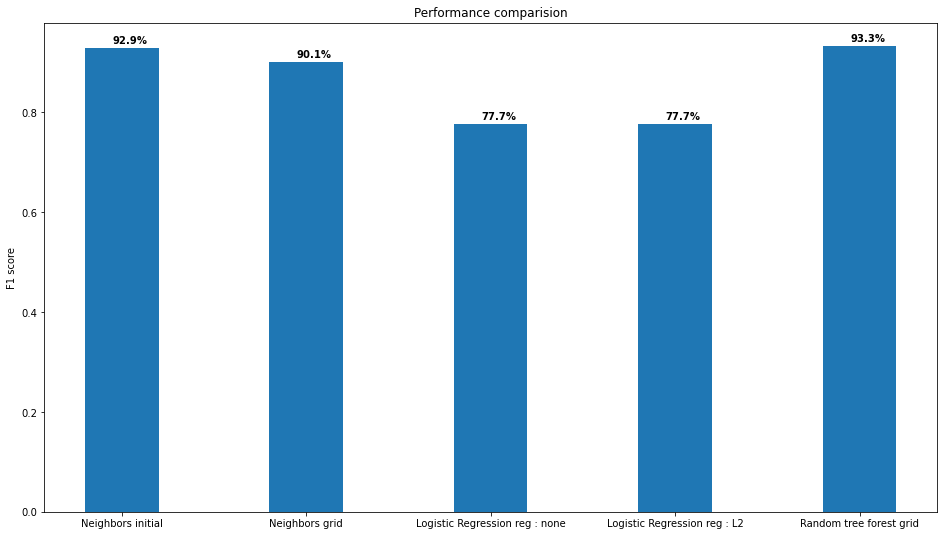

In [34]:
fig = plt.figure(figsize=(16, 9))


import numpy as np
import matplotlib.pyplot as plt
 

    
data = {'Neighbors initial':f1_5NN, 'Neighbors grid':f1_neigh_grid, 'Logistic Regression reg : none':f1_logreg_none,
        'Logistic Regression reg : L2':f1_logreg_ridge, 'Random tree forest grid': f1_forest }
model = list(data.keys())
f1_score = list(data.values())
  

plt.bar(model, f1_score,
        width = 0.4)
plt.ylabel("F1 score")
for index, value in enumerate(f1_score):
    plt.text(index -0.05 , value+0.01, str(round(value*100,1))+"%", fontweight = 'bold')
plt.title("Performance comparision")
plt.show()


#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

En se basant sur le F1-score, le modele ayant le meilleur score est celui utilisant une forêt aléatoire.
L'hyper paramètre associé est n_estimators= 500

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [35]:
df_prive = pd.read_csv('data/foret_prive.tsv' , delimiter='\t')
X_private = np.array(df_prive)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [36]:
standard_scaler2 = preprocessing.StandardScaler()
standard_scaler2.fit(X_public)
X_public_preprocessed = standard_scaler2.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [37]:
standard_scaler3 = preprocessing.StandardScaler()
standard_scaler3.fit(X_private)
X_private_preprocessed = standard_scaler3.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [38]:
predict_forest_final = RandomForestClassifier(n_estimators=500)
predict_forest_final.fit(X_public_preprocessed,y_public)

RandomForestClassifier(n_estimators=500)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [39]:
y_pred_final=predict_forest_final.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [40]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.

In [41]:
#Pré-traitement : transformation minmax
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_train)
X_train_minmax = minmax_scaler.transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

#KNN
predictor_neigh_minmax = neighbors.KNeighborsClassifier()

tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid_minmax_neigh = GridSearchCV(predictor_neigh_minmax, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_minmax_neigh.fit(X_train, y_train)

neigh_minmax = grid_minmax_neigh.best_estimator_
neigh_minmax.fit(X_train_minmax,y_train)
f1_score_minmax_neigh = metrics.f1_score(y_test,neigh_minmax.predict(X_test_minmax))
print("Performance de KNN sur le set de test : {}".format(f1_score_minmax_neigh))

#Regression Logistique pénalisée l2

predictor_logreg_minmax = LogisticRegression(penalty='l2')
tuned_parameters = [{'C': C_values}]
nb_folds = 5
grid_minmax_ridge = GridSearchCV(predictor_logreg_minmax, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_minmax_ridge.fit(X_train_minmax, y_train)

logreg_minmax = grid_minmax_ridge.best_estimator_
logreg_minmax.fit(X_train_minmax,y_train)
f1_score_minmax_logreg = metrics.f1_score(y_test,logreg_minmax.predict(X_test_minmax))
print("Performance de la régression Logistique sur le set de test : {}".format(f1_score_minmax_logreg))

#Forêt Aléatoire

predictor_forest_minmax = RandomForestClassifier()
n_values = np.arange(300, 800, 100)
# define gridsearch
tuned_parameters = [{'n_estimators': n_values}]
nb_folds = 5
grid_minmax_forest = GridSearchCV(predictor_forest_minmax, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_minmax_forest.fit(X_train_minmax, y_train)

forest_minmax = grid_minmax_forest.best_estimator_
forest_minmax.fit(X_train_minmax,y_train)
f1_score_minmax_forest = metrics.f1_score(y_test,forest_minmax.predict(X_test_minmax))
print("Performance de la forêt aléatoire sur le set de test : {}".format(f1_score_minmax_forest))

Performance de KNN sur le set de test : 0.9066874027993779
Performance de la régression Logistique sur le set de test : 0.7768595041322314
Performance de la forêt aléatoire sur le set de test : 0.9404186795491144


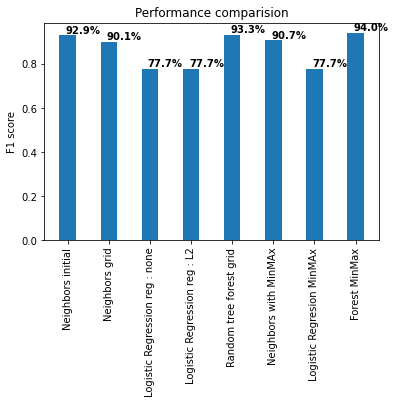

In [42]:
data = {'Neighbors initial':f1_5NN, 'Neighbors grid':f1_neigh_grid, 'Logistic Regression reg : none':f1_logreg_none,
        'Logistic Regression reg : L2':f1_logreg_ridge, 'Random tree forest grid': f1_forest, "Neighbors with MinMAx" : f1_score_minmax_neigh,
        "Logistic Regresion MinMAx" : f1_score_minmax_logreg, "Forest MinMax" : f1_score_minmax_forest}

model = list(data.keys())
f1_score = list(data.values())
  

plt.bar(model, f1_score,
        width = 0.4)

plt.ylabel("F1 score")
for index, value in enumerate(f1_score):
    plt.text(index -0.05 , value+0.01, str(round(value*100,1))+"%", fontweight = 'bold')
plt.xticks(rotation = 90)
plt.title("Performance comparision")
plt.show()

Il semble donc qu'appliquer une transfromation minmax puis un algorithme de forêt alétoire conduirait à de meilleurs résultats

Nous ne traitons pas la transformation Box-Cox car certaines valeurs sont négatives

Nous allons essayer de réduire la dimension :

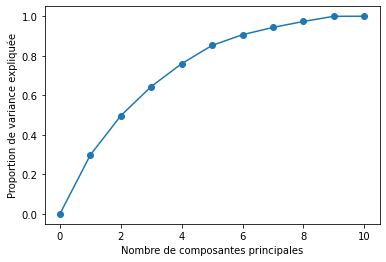

In [43]:
#Réduction de dimension :

from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(X_train)

cumulative_pca = [0]
for e in pca.explained_variance_ratio_ :
    cumulative_pca.append(e+cumulative_pca[-1])
    
plt.plot(np.arange(11), cumulative_pca, marker='o')

plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")
plt.show()

On se rend compte qu'avec 3 composantes il est possible d'expliquer plus de 50% de la variance, et qu'avec 6 composantes on peut monter à 90% de la variance.

Nous allons comparer les résultats obtenus en projettant sur les 6 premières composantes.

In [44]:
pca1 = decomposition.PCA(n_components=6)
pca1.fit(X_train)
X_train_proj = pca1.transform(X_train)
pca2 = decomposition.PCA(n_components=6)
pca2.fit(X_train)
X_test_proj = pca2.transform(X_test)

In [45]:
#KNN
predictor_neigh_proj = neighbors.KNeighborsClassifier()

tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid_proj_neigh = GridSearchCV(predictor_neigh_proj, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_proj_neigh.fit(X_train_proj, y_train)

neigh_proj = grid_proj_neigh.best_estimator_
neigh_proj.fit(X_train_proj,y_train)
f1_score_proj_neigh = metrics.f1_score(y_test,neigh_proj.predict(X_test_proj))
print("Performance de KNN sur le set de test : {}".format(f1_score_proj_neigh))

#Regression Logistique pénalisée l2

predictor_logreg_proj = LogisticRegression(penalty='l2')
tuned_parameters = [{'C': C_values}]
nb_folds = 5
grid_proj_ridge = GridSearchCV(predictor_logreg_proj, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_proj_ridge.fit(X_train_proj, y_train)

logreg_proj = grid_proj_ridge.best_estimator_
logreg_proj.fit(X_train_proj,y_train)
f1_score_proj_logreg = metrics.f1_score(y_test,logreg_proj.predict(X_test_proj))
print("Performance de la régression Logistique sur le set de test : {}".format(f1_score_proj_logreg))

#Forêt Aléatoire

predictor_forest_proj = RandomForestClassifier()
n_values = np.arange(300, 800, 100)
# define gridsearch
tuned_parameters = [{'n_estimators': n_values}]
nb_folds = 5
grid_proj_forest = GridSearchCV(predictor_forest_proj, tuned_parameters, cv=nb_folds, refit=True, scoring=metrics.make_scorer(metrics.f1_score))
grid_proj_forest.fit(X_train_proj, y_train)

forest_proj = grid_proj_forest.best_estimator_
forest_proj.fit(X_train_proj,y_train)
f1_score_proj_forest = metrics.f1_score(y_test,forest_proj.predict(X_test_proj))
print("Performance de la forêt aléatoire sur le set de test : {}".format(f1_score_proj_forest))

Performance de KNN sur le set de test : 0.875968992248062
Performance de la régression Logistique sur le set de test : 0.7440381558028617
Performance de la forêt aléatoire sur le set de test : 0.885691446842526


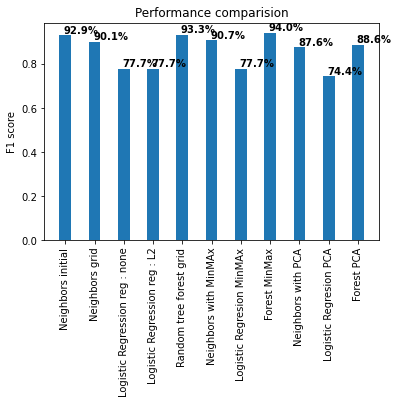

In [46]:
data = {'Neighbors initial':f1_5NN, 'Neighbors grid':f1_neigh_grid, 'Logistic Regression reg : none':f1_logreg_none,
        'Logistic Regression reg : L2':f1_logreg_ridge, 'Random tree forest grid': f1_forest, "Neighbors with MinMAx" : f1_score_minmax_neigh,
        "Logistic Regresion MinMAx" : f1_score_minmax_logreg, "Forest MinMax" : f1_score_minmax_forest, "Neighbors with PCA" : f1_score_proj_neigh,
        "Logistic Regresion PCA" : f1_score_proj_logreg, "Forest PCA" : f1_score_proj_forest}

model = list(data.keys())
f1_score = list(data.values())
  

plt.bar(model, f1_score,
        width = 0.4)

plt.ylabel("F1 score")
for index, value in enumerate(f1_score):
    plt.text(index -0.05 , value+0.01, str(round(value*100,1))+"%", fontweight = 'bold')
plt.xticks(rotation = 90)
plt.title("Performance comparision")
plt.show()

Au vu de tous ces résultats, la meilleur méthode semble être celle d'un forêt aléatoire entrainée avec un jeu de données transformé par une transformation Min Max